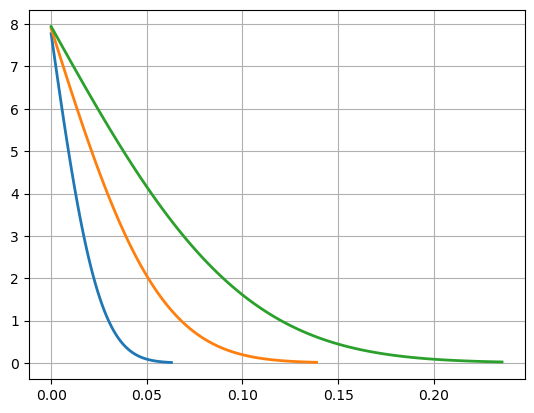

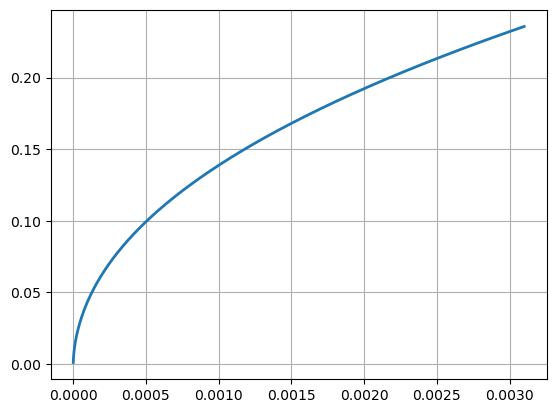

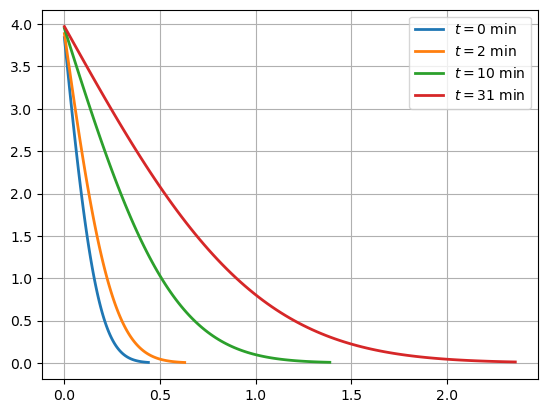

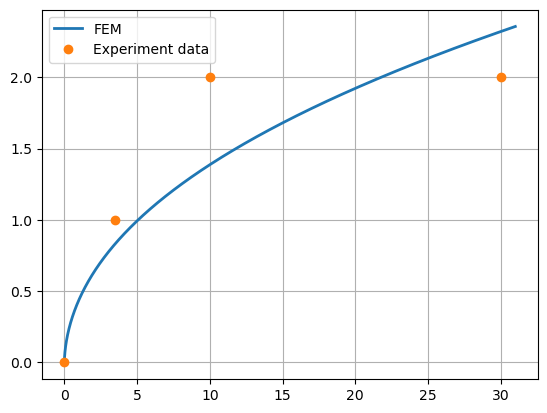

computation time= 0.07155441443125407 minute(s)


In [6]:
#rubber problem by FEM. 
#This is the Python code for solving the rubber probllem by FEM to produced Figure 2 in our GRW paper.  
#"Global random walk for one-dimensional one-phase Stefan-type moving-boundary problems: Simulation results" 
#by Nicolae Suciu, Surendra Nepal, Yosief Wondmagegne, Magnus Ögren, and Adrian Muntean

#import libraries
from numpy import * 
from pylab import *
from scipy.io import savemat 
import scipy.sparse  
from scipy.sparse import diags 
from scipy.integrate import odeint 
import matplotlib.pyplot as plt
import time 

#comouting time
start_time = time.time()
D = 0.01 #mm^2/minute 
beta = 0.564# mm/minute#
H = 2.5 # Henry's constant (dimensionless)

#### parameter based on experimental
S_0 = 0.01 #initial penetration height
x_ref = 10 ##characterstic length x_ref
####
a_0 = 50
m_0 = 0.5
m_ref = m_0

### constraints paramter 
b = 10

#dimensionless number
A_0 = a_0*m_ref*x_ref/D
Bi = beta*x_ref/D

#######
h_0 = S_0/x_ref

####time #####
T_f = 31 #final time in dimension form (minutes)

t_ref = x_ref**2/D ## time scale

Tmax= 0.0031
dt_f = 5e-9
T= int(ceil(Tmax/dt_f))

#T = int(T_f/deltaT) # total number of nodes in time step
T_exp = [1, 2, 10, Tmax*t_ref]# interested to see the plots in these time (minutes)
T_dim = [round(number/(t_ref*dt_f))-15 for number in T_exp] # time slice to plot the experiment 

###space discretization in dimensionless form
N = 101
x = linspace(0,1,N) 
h = 1/(N -1) 

##### tridiagonal matrix for M time derivative 
M = diags([h/6, 2*h/3, h/6], [-1, 0, 1], shape=(N, N)).toarray() 
M[0,0] = M[0, 0]/2 
M[N-1, N-1] =  M[N-1, N-1]/2 
Min = linalg.inv(M) 

#######tridiagonal matrix for K (grad(u).grad(phi)) 
K = diags([-1/h, 2/h, -1/h], [-1, 0, 1], shape=(N, N)).toarray() 
K[0,0] = K[0, 0]/2 
K[N-1, N-1] =  K[N-1, N-1]/2 

######## tridigonal matrix for mixed term  
diagonals = zeros((3, N))   # 3 diagonals 
for i in range(1, N-1): 
    diagonals[1,i] = -h/3  
diagonals[1, 0] = -1/6*(h +3*x[0]) #h/3 - x[1]/2  
diagonals[1, N-1] =  1/6*(3*x[N-1]-h) #h/3 - x[N-2]/2     
for i in range(N-1):     
    diagonals[2,i+1] = x[i+1]/2 - h/3 
for i in range(N-1):     
    diagonals[0,i] = -(x[i]/2 + h/3)   
k = array([diagonals[0,0:N-1], diagonals[1], diagonals[2,1:]], dtype=object) 
A = diags(k,[-1,0,1]).toarray() 

#vectors e_1 and e_{N} (it is needed for boundary terms)
E1 = N*[0] 
E1[0] = 1
EN = N*[0]
EN[N-1] = 1

In = [0.5] #rho 

Sigma_t = []
MV_BC = []
for rho in In:
    def Model(u, t): 
        dwdt = A_0*(u[N-1] - rho/x_ref*u[N]/m_ref) 
        dudt = (dwdt/u[N])*dot(dot(Min, A), u[0:N]) - (1/(u[N])**2)*dot(dot(Min, K), u[0:N]) + (1/u[N])*Bi*(b/m_ref - H*u[0])*dot(Min,E1) - (dwdt/u[N])*u[N-1]*dot(Min,EN)   
        dudt = list(dudt) 
        dudt.append(dwdt) 
        return dudt
    u0 = (N)*[m_0/m_ref] 
    u0.append(h_0) 

    #time discretization
    t = linspace(0, Tmax, T) 
    
     #solve ODE 
    z = odeint(Model, u0, t) 
    m = z[:,:]
    hh=z[:,-1] #extracting the data of moving boundary
    
    hhh = np.array(hh) #conveting the data into numpy array
    
     ######trasnfering back to moving doamin 
    md = np.multiply(x,np.transpose([hh])) #moving domain over time 
    
    ###plot the concentration profile in the dimensionalless form ######
    plt.figure()
    plt.plot(md[T_dim[1], :], m[T_dim[1], :-1], linewidth=2) 
    plt.plot(md[T_dim[2], :], m[T_dim[2], :-1], linewidth=2) 
    plt.plot(md[T_dim[3], :], m[T_dim[3], :-1], linewidth=2) 
    plt.grid()
    plt.show()
    
    #ploting in dimensional variable
    t_1 = t*t_ref #time nodes in moving domain t = tau*t_re
    St = x_ref*hh #z[:,N] # the position of moving boundary s(t) = x_ref*h(tau)
    
    ##########save data for the position of moving front (if you want to save, please uncomment below)
    #savemat("matlab_data_st_FEM_rubber1.mat", dict(t=t_1, s_t=St))
    
     ########### ploting the position of moving boundary in the dimensionalless form ######
    plt.figure()
    plt.plot(t, hh, linewidth=2) 
    plt.grid()
    plt.show()
    
    ########### ploting the concentration profile in the dimensional form ######
    md_d = md*x_ref #moving lenght (domain) in dimensional form)
    plt.figure()
    plt.plot(md_d[T_dim[0],:], m_ref*m[T_dim[0],:-1], linewidth=2)
    plt.plot(md_d[T_dim[1],:],  m_ref*m[T_dim[1],:-1], linewidth=2)
    plt.plot(md_d[T_dim[2],:],  m_ref*m[T_dim[2],:-1], linewidth=2)
    plt.plot(md_d[T_dim[3],:],  m_ref*m[T_dim[3],:-1], linewidth=2)
    plt.legend([r"$t= 0$ min", r"$t = 2$ min", r"$t= 10$ min",\
                r"$t = 31$ min"])
    plt.grid()
    plt.show()
    
    ##########save data for concentration profile (if you want to save, please uncomment below)
    #savemat("matlab_data_con_FEM_rubber1.mat", dict(xx=md_d[T_dim[3],:], c_t_x=m_ref*m[T_dim[3],:-1]))
    
    ####plot the position of moving boundary in dimensional form
    plt.figure()
    plt.plot(t_1, St, linewidth=2) 
    plt.plot([0, 3.5, 10, 30], [0, 1, 2, 2], "o", linewidth=5)
    plt.legend([r"FEM", r"Experiment data"], loc='upper left') 
    plt.grid()
    plt.show()
end_time = time.time()
print('computation time=', (end_time-start_time)/60, 'minute(s)')  